# Customer Churn Analysis




References :

[Kaggle dataset source](https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download&select=WA_Fn-UseC_-Telco-Customer-Churn.csv),

[Github tutorial](https://github.com/pik1989/MLProject-ChurnPrediction/blob/main/Churn%20Analysis%20-%20EDA.ipynb),

[Youtube tutorial related to github](https://www.youtube.com/watch?v=GVECbcKUio4)

## Packages and data importation

In [ ]:
%run /content/drive/MyDrive/churn/Packages.ipynb

# Data Visualisation

In [2]:
churn_df = spark.read.csv('/content/drive/MyDrive/churn/WA_Fn-UseC_-Telco-Customer-Churn.csv', header = True, inferSchema = True)
churn_df.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [9]:
churn_df.count()

7032

Before going deeper, although this dataset is quite small, I believe all the methods used here might need to be scaled-up for larger dataset, so I'm gonna work using pyspark in priority and pandas for some value-added only, or propose some translation. 

## Looking at variable types, convert TotalCharges to integer

In [3]:
churn_df.printSchema()
churn_df = churn_df.withColumn("TotalCharges", churn_df["TotalCharges"].cast(IntegerType()))
churn_df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = tr

Keeping only not null raws

In [4]:
churn_df = churn_df.filter(churn_df.TotalCharges.isNotNull())

#Pandas
#churn_data.TotalCharges = pd.to_numeric(churn_data.TotalCharges, errors = 'coerce')
#churn_data.TotalCharges.isnull().sum()
#churn_data.loc[(churn_data["TotalCharges"].isnull()==True) & (churn_data["Churn"]=="Yes")]

# Data analysis 


First looking at all the features of each string variables

In [8]:
for i in churn_df.drop('Churn','TotalCharges','MonthlyCharges','customerID','tenure'):
  churn_df.select(i).distinct().show()

+------+
|gender|
+------+
|Female|
|  Male|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            1|
|            0|
+-------------+

+-------+
|Partner|
+-------+
|     No|
|    Yes|
+-------+

+----------+
|Dependents|
+----------+
|        No|
|       Yes|
+----------+

+------------+
|PhoneService|
+------------+
|          No|
|         Yes|
+------------+

+----------------+
|   MultipleLines|
+----------------+
|No phone service|
|              No|
|             Yes|
+----------------+

+---------------+
|InternetService|
+---------------+
|    Fiber optic|
|             No|
|            DSL|
+---------------+

+-------------------+
|     OnlineSecurity|
+-------------------+
|                 No|
|                Yes|
|No internet service|
+-------------------+

+-------------------+
|       OnlineBackup|
+-------------------+
|                 No|
|                Yes|
|No internet service|
+-------------------+

+-------------------+
|   DeviceProtection|
+-

In [5]:
for i in churn_df.select('TotalCharges','MonthlyCharges','tenure'):
  print("For the {}".format(i))
  churn_df.agg(round(mean(i),2).alias("Mean"), round(stddev(i),2).alias("Standard Deviation"),round(max(i),2).alias("Maximum"),round(min(i),2).alias("Minimum")).show()

For the Column<'TotalCharges'>
+-------+------------------+-------+-------+
|   Mean|Standard Deviation|Maximum|Minimum|
+-------+------------------+-------+-------+
|2282.83|           2266.77|   8684|     18|
+-------+------------------+-------+-------+

For the Column<'MonthlyCharges'>
+----+------------------+-------+-------+
|Mean|Standard Deviation|Maximum|Minimum|
+----+------------------+-------+-------+
|64.8|             30.09| 118.75|  18.25|
+----+------------------+-------+-------+

For the Column<'tenure'>
+-----+------------------+-------+-------+
| Mean|Standard Deviation|Maximum|Minimum|
+-----+------------------+-------+-------+
|32.42|             24.55|     72|      1|
+-----+------------------+-------+-------+



## Pandas Profiling overview 

It's quite a all-in-one function to discover a dataset, looking for the number of observations, missing cells, duplicate rows, variables types, values of variables, basic statistics and distribution, and when relevant, interactions and correlations

In [6]:
pdp.ProfileReport(churn_df.toPandas())

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Summary of overview



The dataset is composed of 21 variables, each has 7043 raws, no missing values is reported, and no duplicate raws as well. 


---

3 variables are numeric :  

*   Tenure = Number of months the customer has stayed with the company, with the extreme quantiles as maximum (between 0 and 7 months, and between 65 and 72 months)
*   MonthlyCharges = The monthly payment of the customer, with the cheapest the most represented (18.25, no device specified) until 118.25. 
*   TotalCharges, that is mistakenly entered as categorial, but has to be convert as numeric. 

---

5 variables are dummy variables, and 2 variables must be a dummy too :

*   Partner, whether the customer has a partner (Yes), or not (No)
*   Dependents, wheter the customer has dependents (Yes) or not (No)
*   PaperlessBilling, whether the customer has a paperless billing or not 
*   PhoneService, whether the customer has a phone service (Yes) or not (No)
*   And churn, the predict variable as well, with roughly 26% of churners. 

*   Gender, which is almost 50-50 between male and female
*   SeniorCitizen, 1 if yes. 


---

The 12 other variables are categorial, among them we have :

*   MultipleLines, InternetService,  OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, which indicates whether the customer has each item (Yes), or not (No) or even no item service at all, all are independant, with a certain level of correlation between them.  
*  Contract, that indicates how long the contract of the client is, 3 possibilities : month-to-month, 1-year or 2-year
*   PaymentMethod, that indicates how the customer pay, could be automatic (credit card or bank transfer) or by check (mailed or electronic). This last one is the most recurrent, the other roughly equal

---














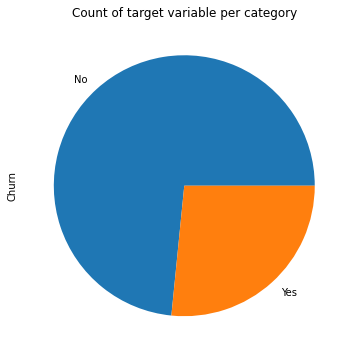

In [8]:
churn_data = churn_df.toPandas()
churn_data['Churn'].value_counts().plot(kind ='pie', figsize =(6,6),
                                        title='Count of target variable per category')

## Churn topic

Among things we must deal with:

*   Unbalanced dataset, we can either upscale the dataset, or downscale it, or even take something to apply the lift metric properly. 
*   Apply and interpret precision (for quality application), recall (for quantity application) and lift 



## Tasks to be done after first overview


*   Boolean and categorial variables (16 of them) have to be encoded, that means change all the (Yes,No) by (1,0) and the correct encoding for variables with at least 3 features.  
*   Total charges has to be converted in numerical variable. 
*   Since the dataset is unbalanced as I expected (27%-73%), I think I have to try two types of model : one with the whole dataset, and one with the top 5% most at-risk churners. 





Step 1. Looking at tenure and pass it in categorial variable, grouping by year

In [11]:
churn_data['tenure'].describe()

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [13]:
import pyspark.sql.functions as F 

In [21]:
churn_df = (churn_df.withColumn('tenure_group',
                                when(col('tenure').between(1,12),"1-12")
                                .otherwise(when(col('tenure').between(13,24),"13-24")
                                  .otherwise(when(col('tenure').between(25,36),"25-36")
                                      .otherwise(when(col('tenure').between(37,48),"37-48")
                                        .otherwise(when(col('tenure').between(49,60),"49-60")
                                          .otherwise("61-72")))))
                                )
)
churn_df.select('tenure_group').distinct().show()
churn_df.filter(churn_df.tenure_group.isNull()).count()

#Pandas
#labels = ["{0}-{1}".format(i,i+11) for i in range(1,72,12)]
#churn_data['tenure_group'] = pd.cut(churn_data.tenure, range(1,80,12), right = False, labels=labels)
#churn_data['tenure_group'].value_counts()

+------------+
|tenure_group|
+------------+
|        1-12|
|       13-24|
|       49-60|
|       61-72|
|       37-48|
|       25-36|
+------------+



0

Step 2. Remove columns not required for modelling

In [ ]:
churn_df = churn_df.drop("customerID",'tenure')
# Pandas
#churn_data.drop(columns=['customerID','tenure'], axis=1, inplace= True)

### Data Exploration

1. Plot distribution of individual predictors by churn

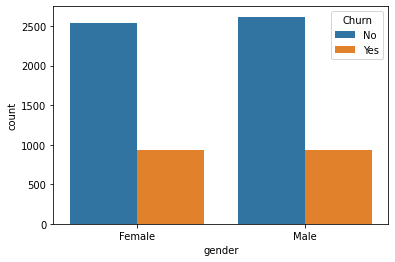

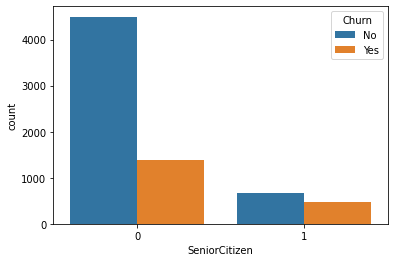

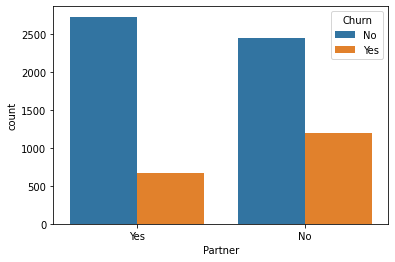

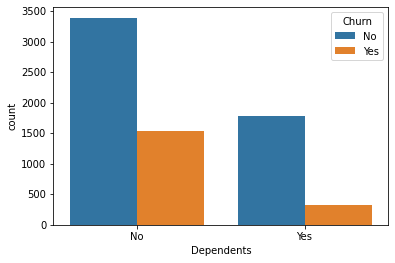

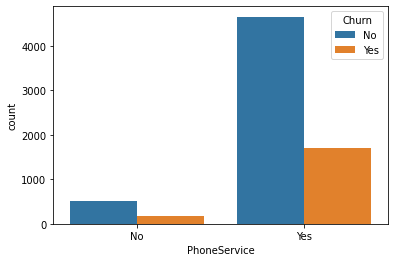

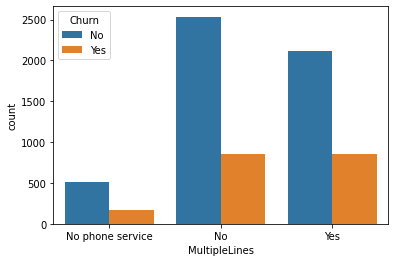

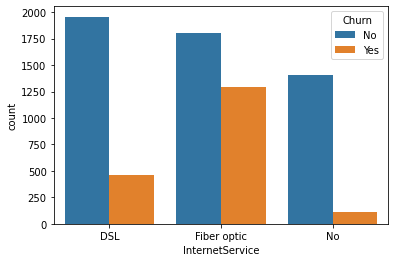

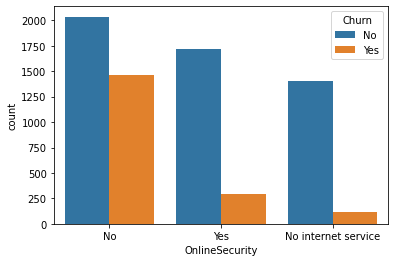

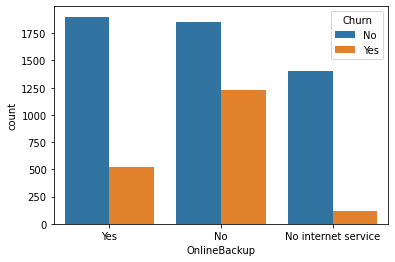

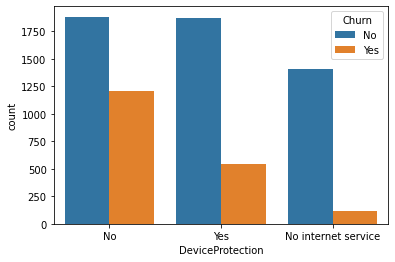

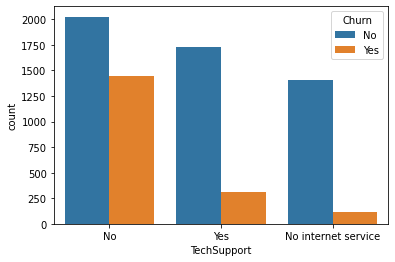

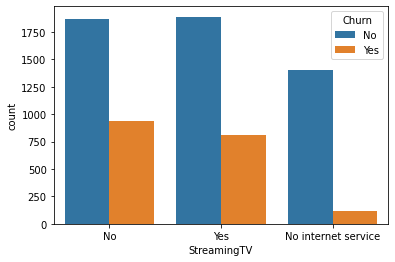

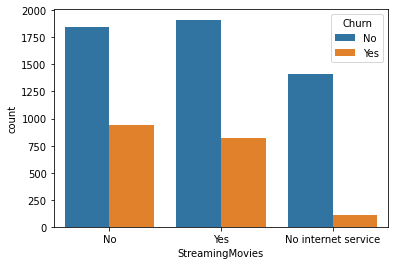

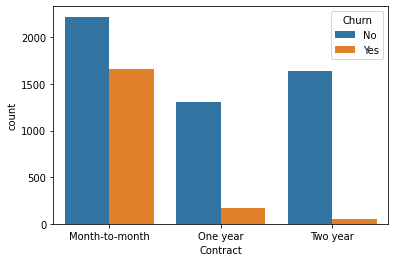

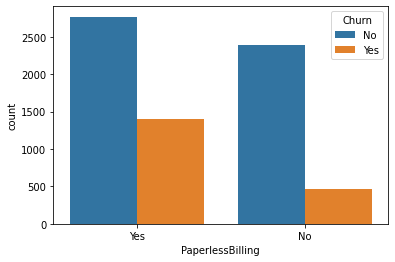

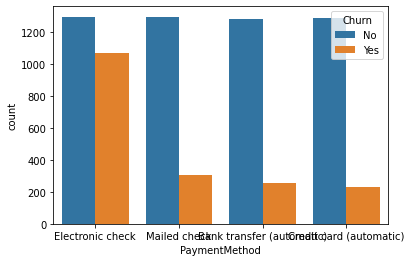

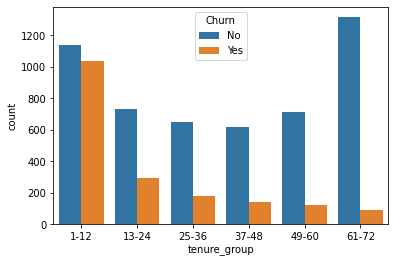

In [14]:
for i, predictor in enumerate(churn_data.drop(columns=['Churn','TotalCharges','MonthlyCharges'])):
  plt.figure(i)
  sns.countplot(data=churn_data, x=predictor, hue='Churn')

## Data preparation for model training 

1.Convert the target variable 'Churn' in a binary numeric variable i.e. Yes = 1; No = 0. 

In [28]:
#nchurn = StringIndexer(inputCol='Churn', outputCol='lapse')
#ntenure_group = StringIndexer(inputCol='tenure_group', outputCol='n_tenure_group')
#ohetenure_group = OneHotEncoder(inputCol='n_tenure_group',outputCol='ohetenure_group')

#features = VectorAssembler(inputCols=[])
#pipeline = Pipeline(stages=[nchurn,ntenure_group,ohetenure_group])
#pipeline.fit(churn_df).transform(churn_df).show(5)

In [15]:
churn_data['Churn'] = np.where(churn_data.Churn=='Yes',1,0)

In [16]:
churn_data['Churn'].value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

3. Convert all the categorical variables into dummy variables

In [39]:
churn_data_dummies = pd.get_dummies(churn_data)
churn_data_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,customerID_0002-ORFBO,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
0,0,1,29.85,29,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
1,0,34,56.95,1889,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,1,0
2,0,2,53.85,108,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
3,0,45,42.30,1840,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,1,0
4,0,2,70.70,151,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


4. Relationship between Monthly Charges and Total Charges

Since inside the pandas profiling Total Charges was a categorial variable, we cannot observe the relationship between theses 2 numeric variables, that might be in relation

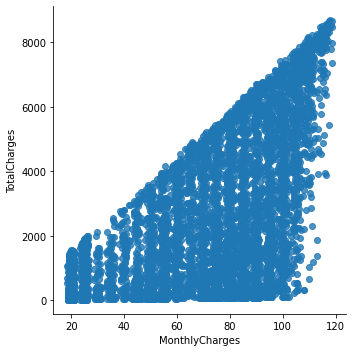

In [18]:
sns.lmplot(data=churn_data_dummies, x='MonthlyCharges', y='TotalCharges',fit_reg = False)

They strongly, with a threshold, increases together

We add the relationship with Churn for both variables

Text(0.5, 1.0, 'Monthly charges by churn')

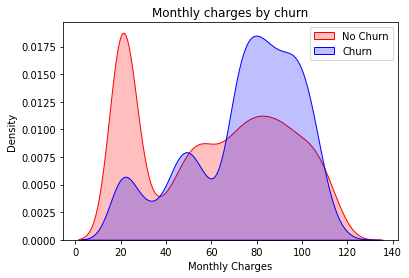

In [19]:
Mth = sns.kdeplot(data=churn_data_dummies.MonthlyCharges[(churn_data_dummies["Churn"]==0)],
                  color ="Red", shade = True)
Mth = sns.kdeplot(data=churn_data_dummies.MonthlyCharges[(churn_data_dummies["Churn"]==1)],
                  ax = Mth, color= "Blue", shade=True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

Churn looks high Monthly Charges are high

Text(0.5, 1.0, 'Total charges by churn')

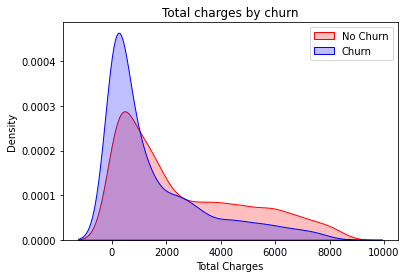

In [20]:
Tot = sns.kdeplot(data=churn_data_dummies.TotalCharges[(churn_data_dummies["Churn"]==0)],
                  color ="Red", shade = True)
Tot = sns.kdeplot(data=churn_data_dummies.TotalCharges[(churn_data_dummies["Churn"]==1)],
                  ax = Tot, color= "Blue", shade=True)
Tot.legend(["No Churn","Churn"],loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Total charges by churn')

Higher churn at lower Total Charges
However if we combine the insights of 3 parameters i.e. Tenure, Monthly Charges & Total Charges then the picture is bit clear :
- Higher Monthly Charge at lower tenure results into lower Total Charge. 
- Hence, all these 3 factors viz Higher Monthly Charge, Lower tenure and Lower Total Charge are linkd to High Churn.

5. Build a correlation of all predictors with 'Churn'

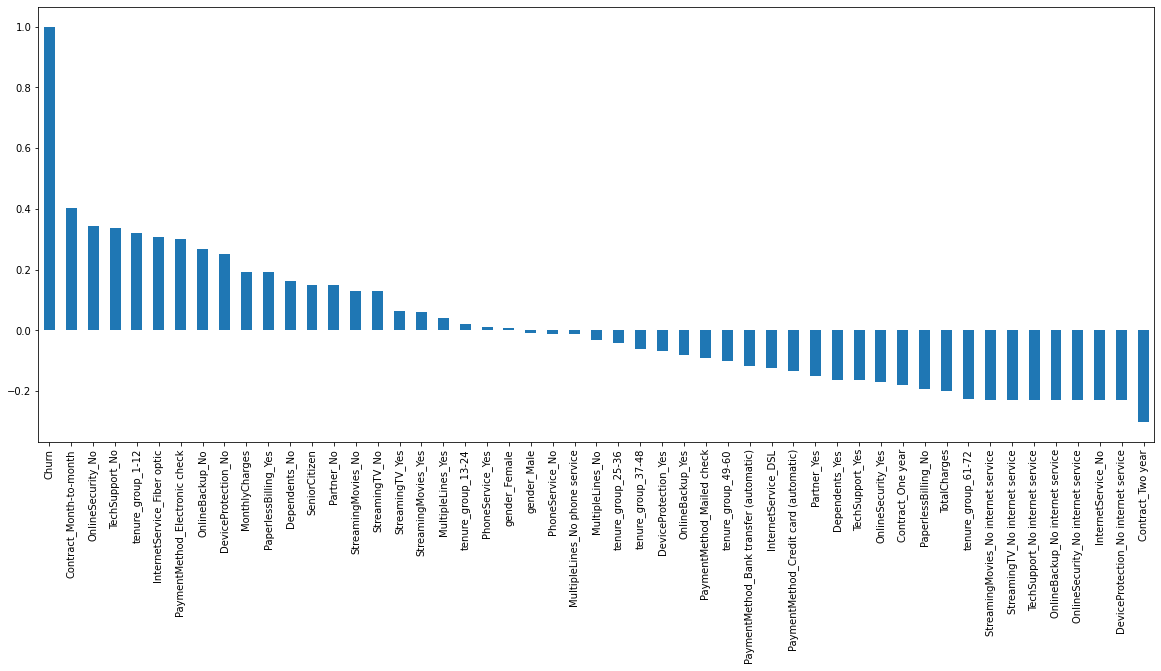

In [21]:
plt.figure(figsize=(20,8))
churn_data_dummies.corr()['Churn'].sort_values(ascending=False).plot(kind='bar')

**Insights from correlation graphs:**

High churn seen in case of **Month-to-month contracts,** **No online security**, **No tech support**, **First year of subscription** and **Fibre Optics internet**

Low churn is seens in case of **Long Term contracts**, **subscriptions without internet service** and **the customers engaged for 5+ years**

Factors like **Gender**, **availability of PhoneService** and **multiple lines** have almost no impact on Churn 

To look at it on another way

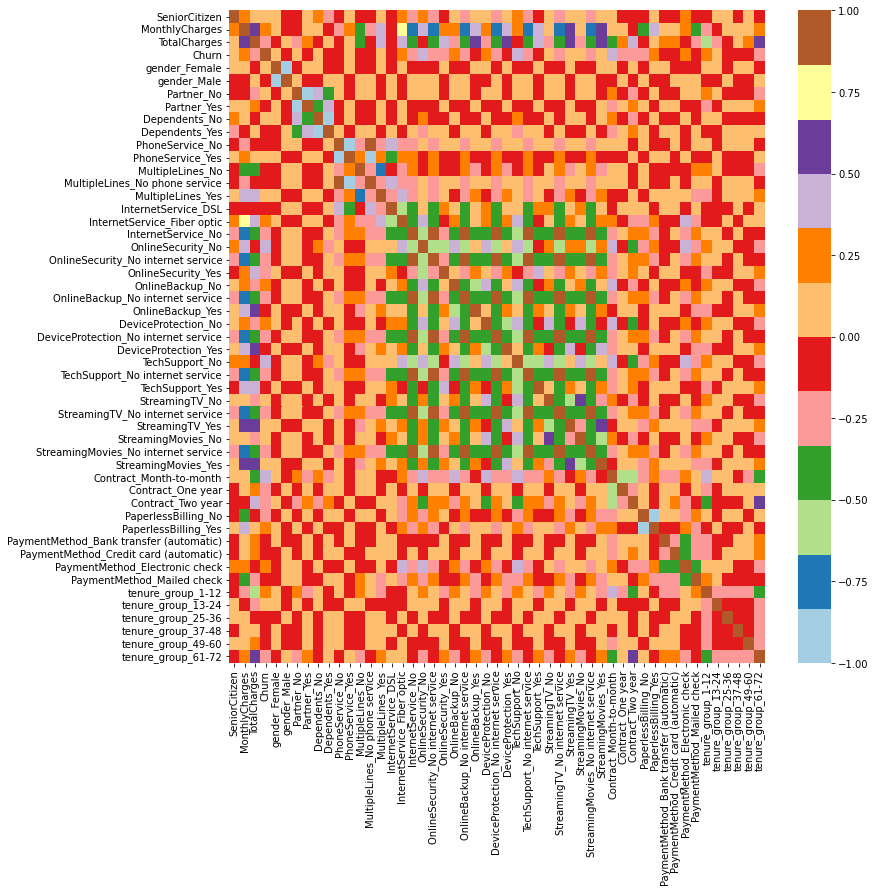

In [22]:
plt.figure(figsize=(12,12))
sns.heatmap(churn_data_dummies.corr(), cmap='Paired')

### How to look more precisily inside the two features of churn

In [23]:
without_churn_df = churn_data.loc[churn_data["Churn"]==0]
with_churn_df = churn_data.loc[churn_data["Churn"]==1]

In [24]:
def uniplot(df,col,title,hue=None):
  sns.set_style('whitegrid')
  sns.set_context('talk')
  plt.rcParams["axes.labelsize"]=16
  plt.rcParams["axes.titlesize"]=18
  plt.rcParams["axes.titlepad"]=26

  temp = pd.Series(data=hue)
  fig, ax = plt.subplots()
  width = len(df[col].unique())+7+4*len(temp.unique())
  fig.set_size_inches(width,8)
  plt.xticks(rotation=45)
  plt.yscale('log')
  plt.title(title)
  ax = sns.countplot(data = df, x = col, order=df[col].value_counts().index, hue=hue,palette='bright')

  plt.show()

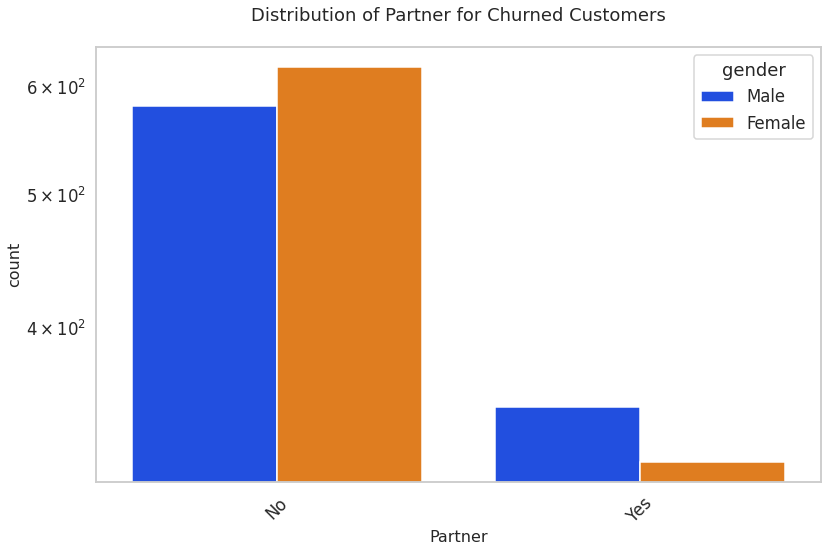

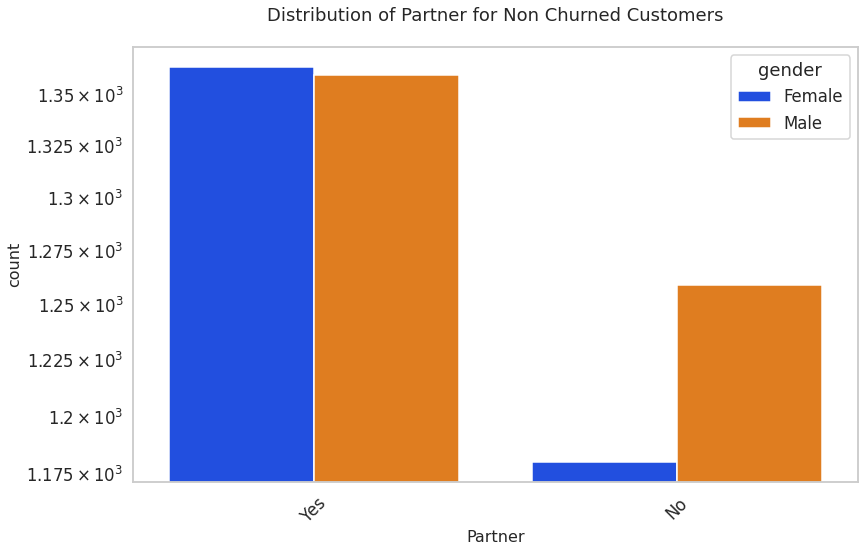

In [25]:
uniplot(with_churn_df,col='Partner',title='Distribution of Partner for Churned Customers',hue='gender')
uniplot(without_churn_df,col='Partner',title='Distribution of Partner for Non Churned Customers',hue='gender')

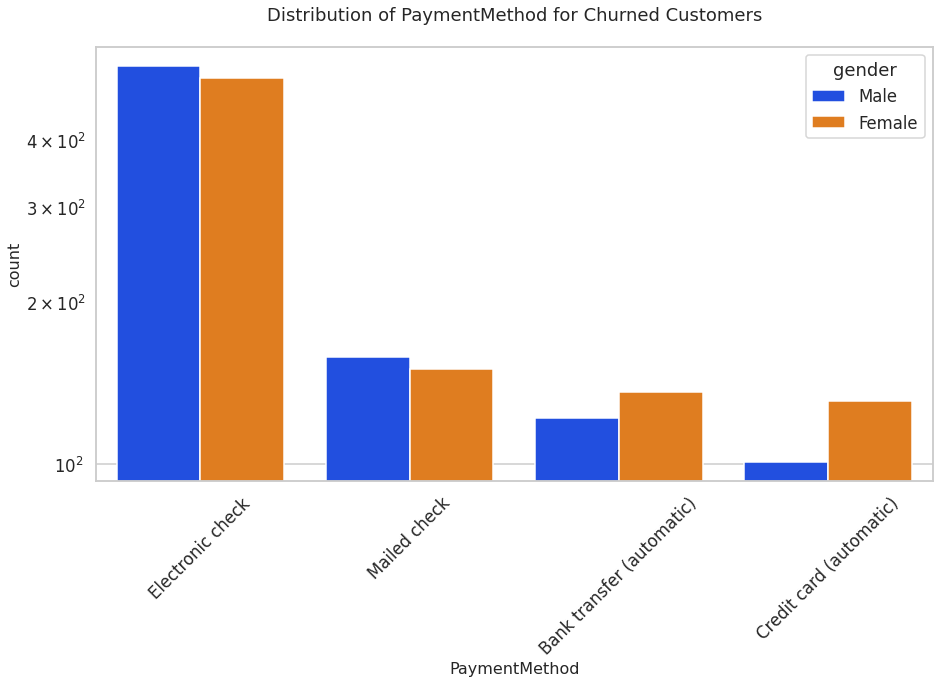

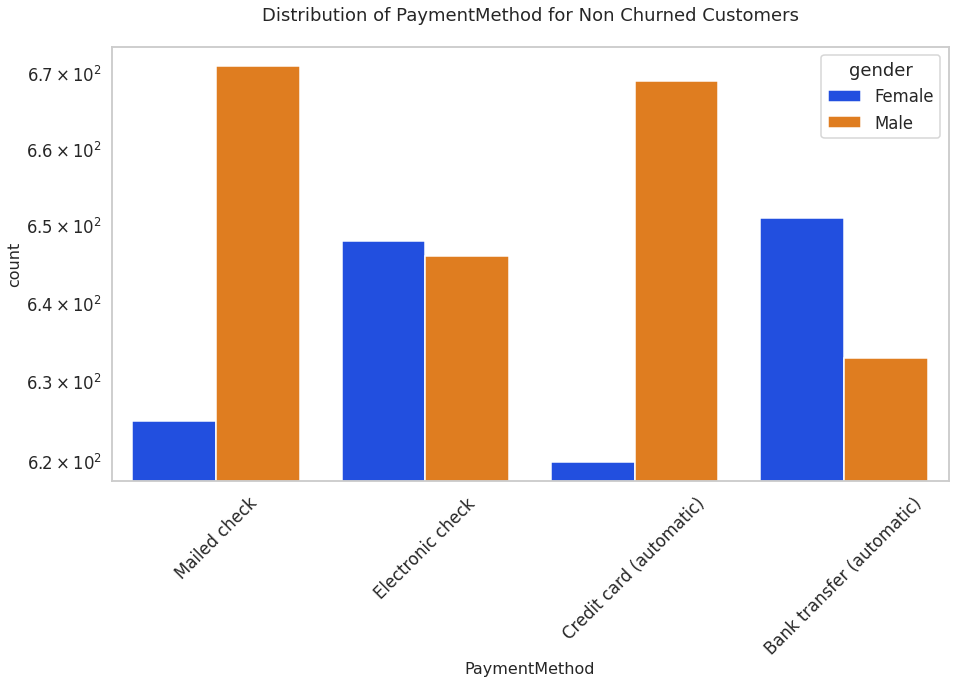

In [26]:
uniplot(with_churn_df,col='PaymentMethod',title='Distribution of PaymentMethod for Churned Customers',hue='gender')
uniplot(without_churn_df,col='PaymentMethod',title='Distribution of PaymentMethod for Non Churned Customers',hue='gender')

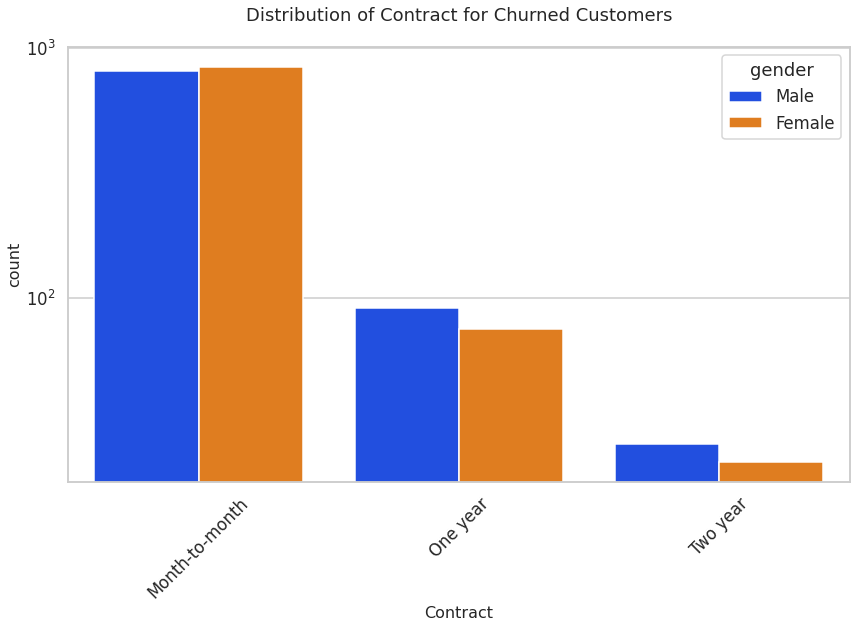

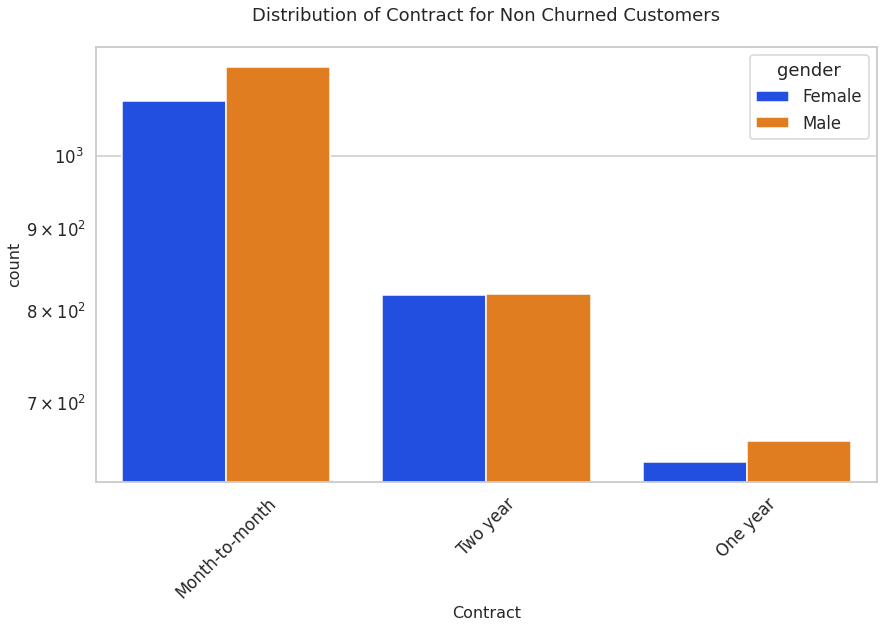

In [27]:
uniplot(with_churn_df,col='Contract',title='Distribution of Contract for Churned Customers',hue='gender')
uniplot(without_churn_df,col='Contract',title='Distribution of Contract for Non Churned Customers',hue='gender')

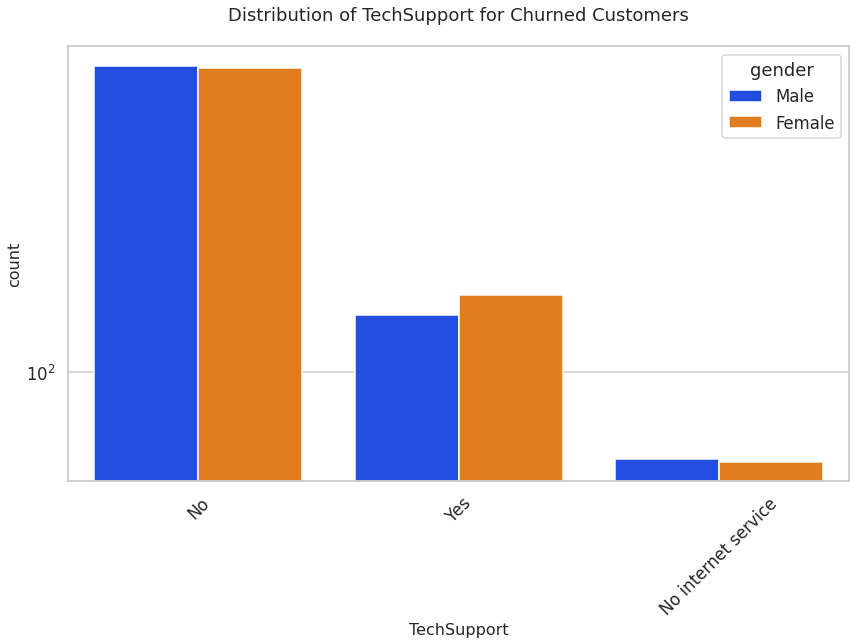

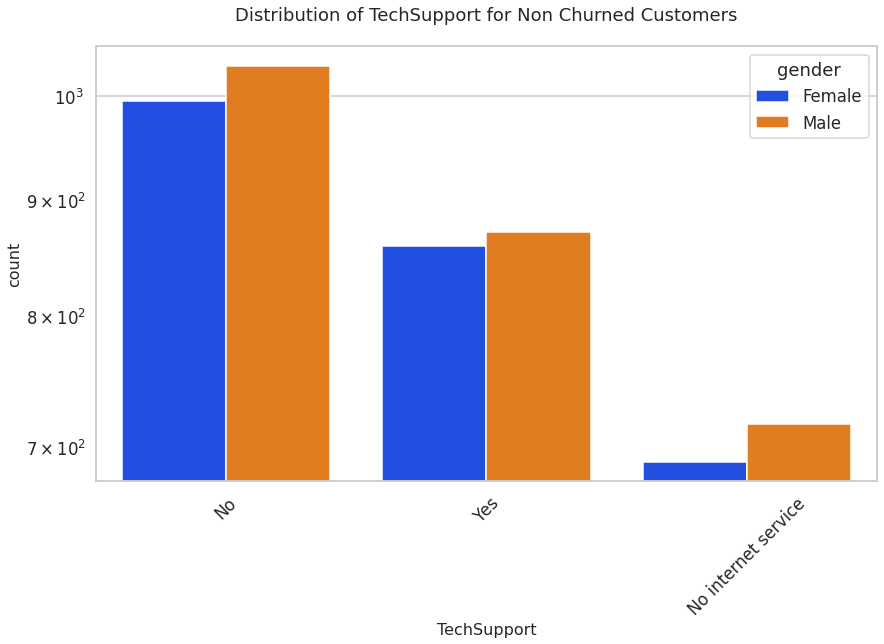

In [28]:
uniplot(with_churn_df,col='TechSupport',title='Distribution of TechSupport for Churned Customers',hue='gender')
uniplot(without_churn_df,col='TechSupport',title='Distribution of TechSupport for Non Churned Customers',hue='gender')

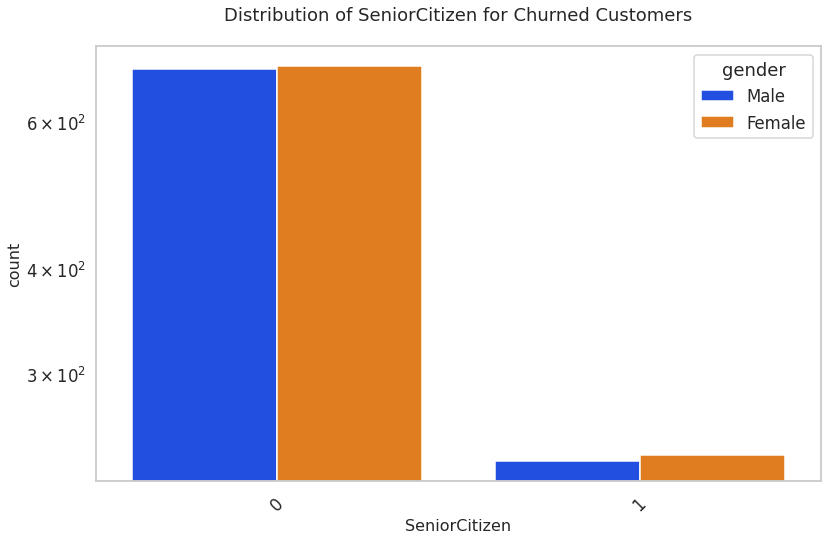

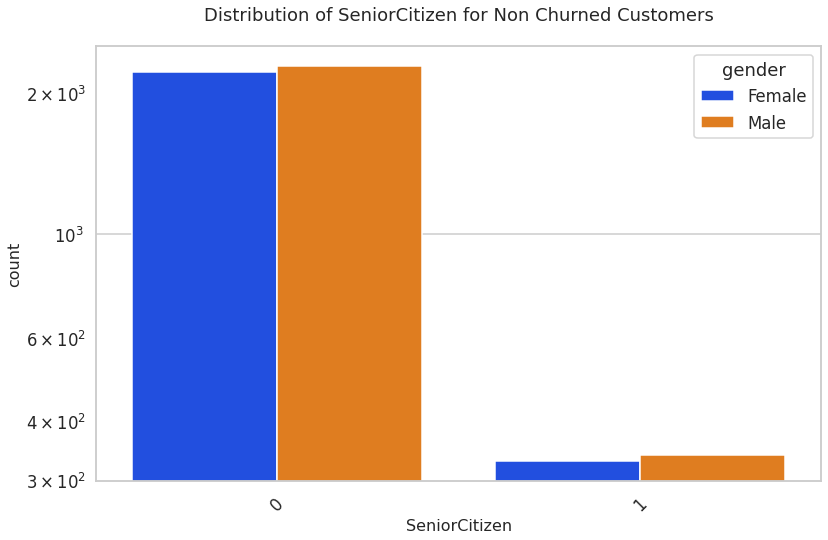

In [29]:
uniplot(with_churn_df,col='SeniorCitizen',title='Distribution of SeniorCitizen for Churned Customers',hue='gender')
uniplot(without_churn_df,col='SeniorCitizen',title='Distribution of SeniorCitizen for Non Churned Customers',hue='gender')

# Conclusion 

1. Electronic check medium are the highest churners
2. Contract Type - Montly customers are more likely to churn of no contract terms, as they are free to go customers.
3. No Online security, No tech Support Category are high churners
4. Non senior Citizens are high churners


In [30]:
churn_data_dummies.to_csv('/content/drive/MyDrive/churn/telco_churn.csv')